In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

from drive.MyDrive.kursach import helpers
path = 'drive/MyDrive/kursach/'

Mounted at /content/drive/


# Подготовка

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 102 kB 8.6 MB/s 
     |████████████████████████████████| 47.6 MB 1.4 MB/s 
albumentations==1.1.0 is successfully installed


In [ ]:
import albumentations as albu
import copy
import cv2
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random
import segmentation_models_pytorch as smp
from sklearn import model_selection
import torch
from torch import nn
from torch.utils import data

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
rand = 51
np.random.seed(rand)
random.seed(rand)
torch.manual_seed(rand)
if device == 'cuda':
  torch.cuda.manual_seed(rand)
  torch.cuda.manual_seed_all(rand)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
im_medseg, mk_medseg, im_radio, mk_radio = helpers.load_datasets(path, size=(256, 256))

Added drive/MyDrive/kursach/raw-data-kaggle/images_medseg.npy, shape (1, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_medseg.npy, shape (4, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/images_radiopedia.npy, shape (1, 829, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_radiopedia.npy, shape (4, 829, 256, 256)


In [ ]:
gc.collect()

74

# Основные классы и функции

In [ ]:
class Dataset(data.Dataset):
  def __init__(self, X, y, augmentations=None):
    X = X.reshape(-1, 1, X.shape[1], X.shape[2]).astype(np.float32)
    X = (X - X.min())
    X = X / X.max()
        
    self.X = X
    self.y = y
    self.augmentations = augmentations

  def __len__(self):
    return self.y.shape[0]

  def __getitem__(self, i):
    x_el, y_el = copy.deepcopy(self.X[i]), copy.deepcopy(self.y[i])
    if self.augmentations is not None:
      sample = self.augmentations(image=x_el[0], mask=y_el)
      x_el[0] = sample['image']
      y_el = sample['mask']

    x_el = torch.from_numpy(x_el).to(device)
    y_el = torch.from_numpy(y_el.astype(np.int64)).to(device)

    return x_el, y_el

def get_loader(dataset, batch=64):
  return data.DataLoader(dataset, batch_size=batch)

def prepare_datasets(X, y):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
      X, y, train_size=0.8, random_state=rand)
  train = Dataset(X_train, y_train, train_transform)
  test = Dataset(X_test, y_test, test_transform)
  return train, test

In [ ]:
class Network:
  def __init__(self, model, loss):
    self.model = model.to(device)
    self.best_model = copy.deepcopy(model)
    self.loss = loss
    self.best_loss = 1e10
    self.optim = torch.optim.Adam(self.model.parameters())
    self.loss_history = []

  def fit(self, data, epochs=50, verbose=False, no_improvements_iter=-1):
    data = get_loader(data)
    no_improvements = 0
    for i in range(epochs):
      total_loss = 0
      for X, y in data:
        pred = self.model(X)
        loss = self.loss(pred, y)
        total_loss += loss.detach().to('cpu').item()

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

      if verbose:
        print(f'Epoch {i}, loss {total_loss}')
      self.loss_history.append(total_loss)

      if total_loss < self.best_loss and not math.isclose(total_loss, self.best_loss):
        self.best_loss = total_loss
        self.best_model = copy.deepcopy(self.model)
        no_improvements = 0
      else:
        no_improvements += 1
        print(f'No improvements for {no_improvements} epochs')

      if no_improvements_iter != -1 and no_improvements >= no_improvements_iter:
        break

    self.model = copy.deepcopy(self.best_model)

  def test(self, data, metric, *args):
    data = get_loader(data)
    size = len(data.dataset)
    num_batches = len(data)
    total_metric = 0.

    with torch.no_grad():
      for X, y in data:
        pred = self.model(X).argmax(1)
        if metric == 'accuracy':
          total_metric += self._accuracy(pred, y)
        elif metric == 'iou':
          total_metric += self._iou(pred, y, args[0])

    if metric == 'accuracy':
      total_metric /= size
    elif metric == 'iou':
      total_metric /= num_batches

    return total_metric

  def _accuracy(self, y_pred, y_true):
    im_size = y_pred.shape[1] * y_pred.shape[2]
    return (y_pred == y_true).type(torch.float).sum().item() / im_size

  def _iou(self, y_pred, y_true, class_label):
    y_pred = y_pred == class_label
    y_true = y_true == class_label
    intersection = y_pred & y_true
    union = y_pred | y_true
    return intersection.type(torch.float).sum().item() / union.type(torch.float).sum().item()

In [ ]:
NETWORK_NAMES = ['unet', 'unet++', 'manet', 'deeplab', 'deeplab+']

def create_network(n_classes, name='unet'):
  if name == 'unet':
    return Network(smp.Unet(in_channels=1, classes=n_classes, activation='softmax'),
                   nn.CrossEntropyLoss())
  elif name == 'unet++':
    return Network(smp.UnetPlusPlus(in_channels=1, classes=n_classes, activation='softmax'),
                   nn.CrossEntropyLoss())
  elif name == 'manet':
    return Network(smp.MAnet(in_channels=1, classes=n_classes, activation='softmax'),
                   nn.CrossEntropyLoss())
  elif name == 'deeplab':
    return Network(smp.DeepLabV3(in_channels=1, classes=n_classes, activation='softmax'),
                   nn.CrossEntropyLoss())
  elif name == 'deeplab+':
    return Network(smp.DeepLabV3Plus(in_channels=1, classes=n_classes, activation='softmax'),
                   nn.CrossEntropyLoss())

# Классифицируем

In [ ]:
train_transform = None
test_transform = None

In [ ]:
X = np.concatenate((im_medseg[0], im_radio[0]), axis=0)
y = np.concatenate((mk_medseg, mk_radio), axis=1)
y = y.argmax(0)
X.shape, y.shape

((929, 256, 256), (929, 256, 256))

In [ ]:
architecture = NETWORK_NAMES[3]

train, test = prepare_datasets(X, y)
model = create_network(4, name=architecture)

print('Model: ', architecture)

In [ ]:
model.fit(train, epochs=150, verbose=True, no_improvements_iter=5)

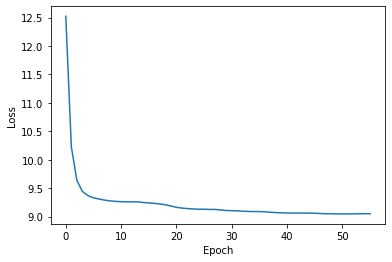

In [ ]:
helpers.plot_loss(model)

In [ ]:
test_report = '{epochs} epochs\nLoss: {loss}\nAccuracy: {accuracy}\n'
accuracy = model.test(test, 'accuracy')
test_report = test_report.format(epochs=len(model.loss_history),
                                 loss=model.best_loss,
                                 accuracy=accuracy)

for i in range(4):
  test_report += f'{helpers.LABELS[i]} IoU: {model.test(test, "iou", i)}\n'

print(test_report)

56 epochs
Loss: 9.048177003860474
Accuracy: 0.9858568253055695
Ground Glass IoU: 0.6160483449117077
Consolidation IoU: 0.4981647997390671
Lungs Other IoU: 0.9215119448482748
Background IoU: 0.9919142665245128



In [ ]:
label_pairs = [('True ' + label, 'Predicted ' + label)
               for label in helpers.LABELS]
# flatten label pairs
labels = [label for pair in label_pairs for label in pair]

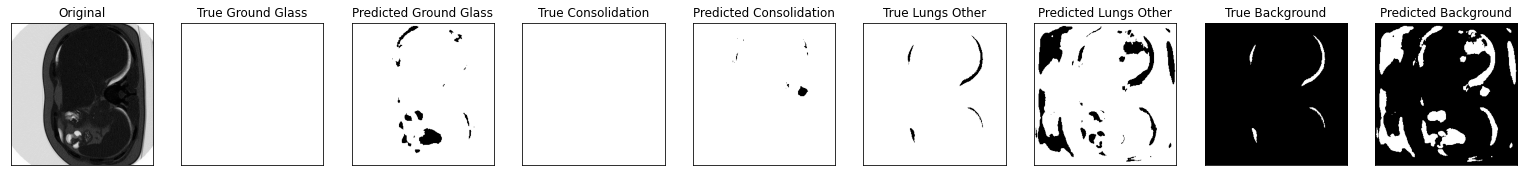

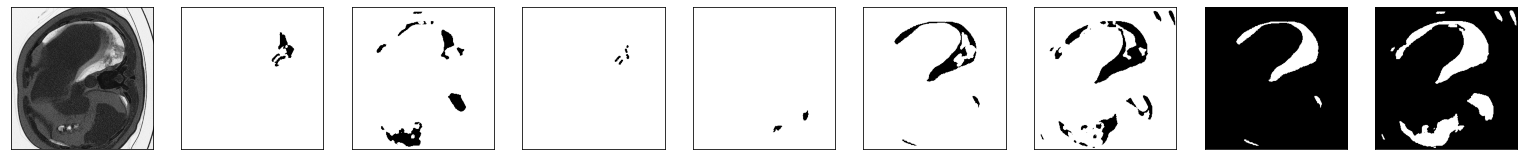

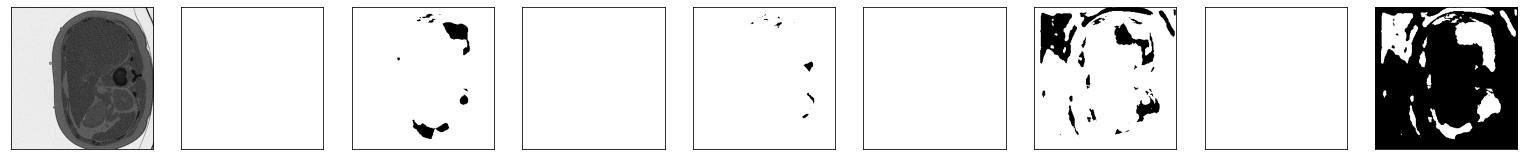

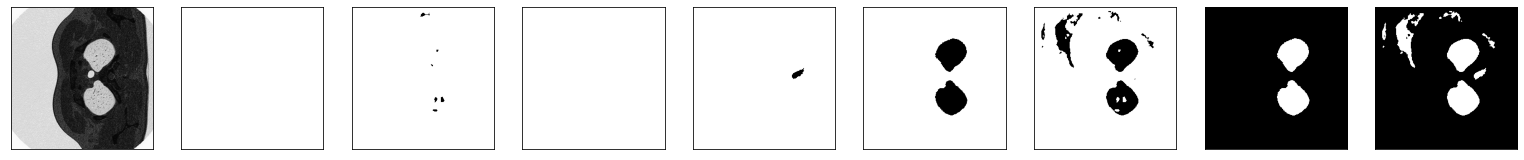

In [ ]:
for i in range(4):
  sample, true_answer = test[i]
  pred_answer = model.model(sample.reshape(1, 1, sample.shape[1], -1)).argmax(1)
  images = [sample[0]]
  for j in range(4):
    images += [true_answer == j, (pred_answer == j)[0]]
  images = [im.cpu().detach().numpy() for im in images]
  titles = ['Original'] + labels if i == 0 else None
  helpers.show_im_row(np.array(images), size=3, titles=titles)

In [ ]:
torch.save(model.model.state_dict(), path + 'deeplab')
drive.flush_and_unmount()